# Medical data visualizer

![separator](img/sep.jpeg)

In this project, we visualize and make calculations from medical examination data using matplotlib, seaborn, and pandas.

In [148]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import random

## 1) Data description

The dataset values were collected during medical examinations. The rows in the dataset represent patients and the columns represent information like body measurements, results from various blood tests, and lifestyle choices. We use the dataset to explore the relationship between cardiac disease, body measurements, blood markers, and lifestyle choices.

| Feature | Variable Type | Variable      | Value Type |
|:-------:|:------------:|:-------------:|:----------:|
| Age | Objective Feature | age | int (days) |
| Height | Objective Feature | height | int (cm) |
| Weight | Objective Feature | weight | float (kg) |
| Gender | Objective Feature | gender | categorical code |
| Systolic blood pressure | Examination Feature | ap_hi | int |
| Diastolic blood pressure | Examination Feature | ap_lo | int |
| Cholesterol | Examination Feature | cholesterol | 1: normal, 2: above normal, 3: well above normal |
| Glucose | Examination Feature | gluc | 1: normal, 2: above normal, 3: well above normal |
| Smoking | Subjective Feature | smoke | binary |
| Alcohol intake | Subjective Feature | alco | binary |
| Physical activity | Subjective Feature | active | binary |
| Presence or absence of cardiovascular disease | Target Variable | cardio | binary |

In [149]:
df = pd.read_csv('files/medical_examination.csv')
df.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


## 2) Outcome comparison chart:

We create a chart where we show the counts of good and bad outcomes for the `cholesterol`, `gluc`, `alco`, `active`, and `smoke` variables for patients with (i.e. `cardio=1`) and without (i.e. `cardio=0`)  cardiac diseases in different panels. 

To do so, we follow the following steps:

* Add an `overweight` column to the data. To determine if a person is overweight, first calculate their BMI by dividing their weight in kilograms by the square of their height in meters. If that value is > 25 then the person is overweight. Use the value 0 for NOT overweight and the value 1 for overweight.

In [150]:
df['overweight'] = np.where( (df['weight'] / (df['height'] * 0.01) ** 2) > 25, 1, 0)
df.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,overweight
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1,0
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0,0


* Normalize the data by making 0 always good and 1 always bad:

In [151]:
df.loc[(df['cholesterol'] == 1),'cholesterol'] = 0
df.loc[(df['cholesterol'] > 1),'cholesterol'] = 1

df.loc[(df['gluc'] == 1),'gluc'] = 0
df.loc[(df['gluc'] > 1),'gluc'] = 1

* Create DataFrame for cat plot using `pd.melt` using just the values from 'cholesterol', 'gluc', 'smoke', 'alco', 'active', and 'overweight'.

In [152]:
df_cat = pd.melt(df, id_vars=['cardio'], 
                  value_vars=['cholesterol', 'gluc', 'smoke', 'alco', 'active', 'overweight'])

df_cat.head()

,cardio,variable,value
0,0,cholesterol,0
1,1,cholesterol,1
2,1,cholesterol,1
3,1,cholesterol,0
4,0,cholesterol,0


* Group and reformat the data to split it by 'cardio' and show the counts of each feature:

In [153]:
df_cat['total'] = np.random.randn()
df_cat = df_cat.groupby(['variable', 'cardio', 'value'], as_index=False).count()

In [154]:
df_cat.head()

,variable,cardio,value,total
0,active,0,0,6378
1,active,0,1,28643
2,active,1,0,7361
3,active,1,1,27618
4,alco,0,0,33080


* Draw the catplot with `sns.catplot()`: The dataset should be split by 'Cardio' so there is one chart for each `cardio` value.

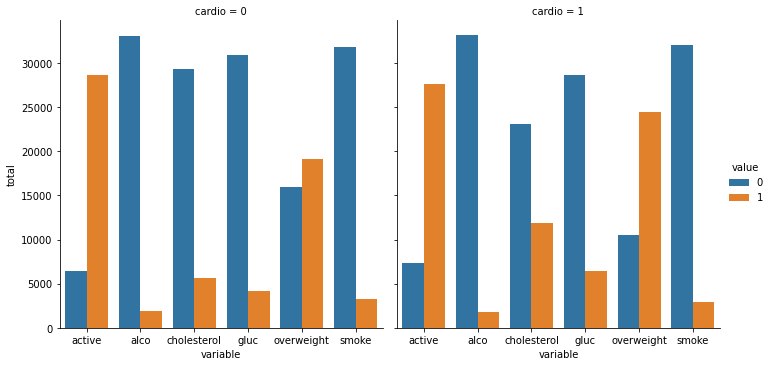

In [159]:
graph = sns.catplot(
    x = 'variable', 
    y = 'total', 
    hue = 'value', 
    data = df_cat, 
    col = 'cardio', 
    kind = 'bar')

We can see the count of **GOOD** outcomes in <span style="color:blue">**blue**</span> and **BAD** outcomes in <span style="color:orange">**orange**</span> for patients with and without cardiac disease.

## 3) Exploring corrolations:

Now we explore the relationship between the measured variables and show it in the form of a *Heat map*. 

We proceed as follow:

* Clean the data. Filter out the following patient segments that represent incorrect data:
  - diastolic pressure is higher than systolic
  - height is less than the 2.5th percentile
  - height is more than the 97.5th percentile
  - weight is less than the 2.5th percentile
  - weight is more than the 97.5th percentile

In [80]:
mask1 = (df['ap_lo'] <= df['ap_hi'])
mask2 = (df['height'] >= df['height'].quantile(0.025)) & (df['height'] <= df['height'].quantile(0.975))
mask3 = (df['weight'] >= df['weight'].quantile(0.025)) & (df['weight'] <= df['weight'].quantile(0.975))

df_heat = df[mask1 & mask2 & mask3]

* Create a correlation matrix using the dataset:

In [115]:
corr_mtrx = df_heat.corr()

Mask the upper triangle: This is because corelation matrices are symmetrical, half of it suffices to analyze correctly the data.

In [116]:
mask = np.triu(np.ones(corr_mtrx.shape),0)

Set up the matplotlib figure and plot the correlation matrix using seaborn's `heatmap()`:

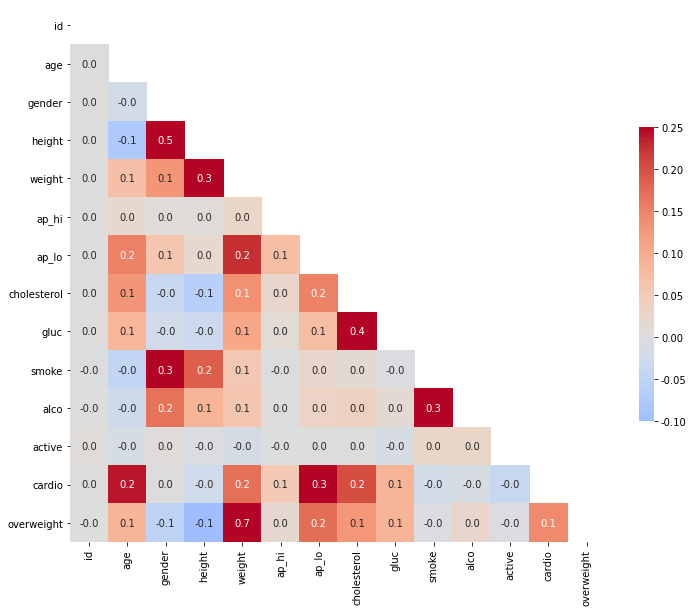

In [161]:
fig, ax = plt.subplots(figsize=(12,12))
ax = sns.heatmap(
    data=corr_mtrx,
    cmap='coolwarm',
    vmin = -0.1,
    vmax = 0.25,
    center = 0,
    robust=True,
    annot = True,
    fmt = '.1f',
    square = True,
    cbar_kws={
            'shrink': .45,
            'format': '%.2f'
        },
    mask=mask)